### Project Goal :

The goal of this project is to develop a machine learning model to predict customer churn for Beta Bank. By analyzing customer behavior and account features, the bank aims to identify clients who are likely to terminate their contracts in the near future.

Successfully predicting churn will enable the bank to take proactive steps to retain at-risk customers, thereby reducing attrition and improving customer lifetime value.

To consider the model successful, it must achieve an **F1 score of at least 0.59** on the test set. We will also evaluate performance using the **AUC-ROC** metric to assess the model’s ability to distinguish between churned and retained customers.

In [41]:
#Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import matplotlib.pyplot as plt

In [42]:
#Load Data
data = pd.read_csv("/datasets/Churn.csv")
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [43]:
#prepare the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [44]:
#we see the column 'Tenure' has 909 missing data 
data.isna().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [45]:
#Handle Missing Values
#data['Tenure'] = data['Tenure'].fillna('Unknown')
data['Tenure'] = data['Tenure'].fillna(data['Tenure'].median())

In [46]:
data.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [47]:
#Drop Irrelevant Columns
data = data.drop(['RowNumber','CustomerId','Surname'], axis=1)

In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  float64
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


In [49]:
#Encode Categorical Variables
data = pd.get_dummies(data, columns=['Gender'] )
data = pd.get_dummies(data, columns=['Geography'], drop_first=True)

In [50]:
data.columns

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited', 'Gender_Female',
       'Gender_Male', 'Geography_Germany', 'Geography_Spain'],
      dtype='object')

In [51]:
#Separate Features and Target
featuer = data.drop('Exited', axis=1)
target = data['Exited']

In [52]:
#Train-Left Split (60% train, 40% Lfet)
featuer_train, featuer_left, target_train, target_left = train_test_split(
    featuer, target, test_size= 0.40, random_state=12345)
#Valid-test Split (20% valid, 20 test)
featuer_valid,featuer_test,target_valid, target_test = train_test_split(
    featuer_left, target_left, test_size= 0.50, random_state=12345)

In [53]:
#Feature Scaling
scaler = StandardScaler()
featuer_train_scaled = scaler.fit_transform(featuer_train)
featuer_valid_scaled = scaler.transform(featuer_valid)
featuer_test_scaled = scaler.transform(featuer_test)

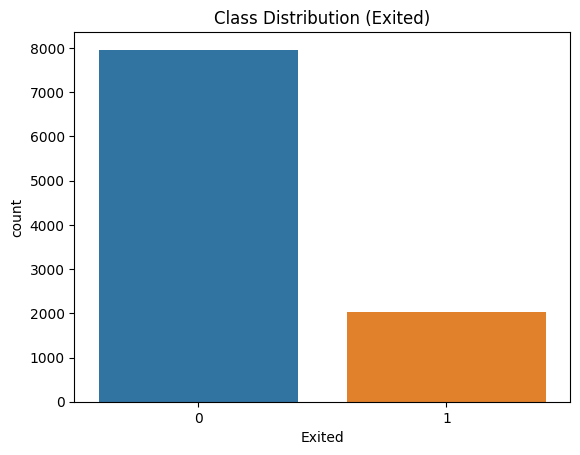

0    0.7963
1    0.2037
Name: Exited, dtype: float64


In [54]:
#Check Class Balance 
sns.countplot(x=target)
plt.title("Class Distribution (Exited)")
plt.show()
print(target.value_counts(normalize=True))

**The target variable Exited is imbalanced: approximately %79.6 of customers stayed and %20.3 exited. This confirms the need to handle class imbalance later. First, we’ll train baseline models without applying any class balancing techniques.**

In [55]:
#Train Baseline Models (No Balancing techniques)
models = {
    'Logistic Regression': LogisticRegression(random_state=12345),
    'Decision Tree': DecisionTreeClassifier(random_state=12345),
    'Random Forest': RandomForestClassifier(random_state=12345)
}

for name, model in models.items():
    model.fit(featuer_train_scaled, target_train)
    pred = model.predict(featuer_valid_scaled)
    f1 = f1_score(target_valid, pred)
    pred_prob = model.predict_proba(featuer_valid_scaled)
    roc_auc = roc_auc_score(target_valid, pred_prob [:, 1])
    print(f"{name} — F1 Score: {f1:.3f} | AUC-ROC: {roc_auc:.3f}")


Logistic Regression — F1 Score: 0.331 | AUC-ROC: 0.759
Decision Tree — F1 Score: 0.496 | AUC-ROC: 0.681
Random Forest — F1 Score: 0.555 | AUC-ROC: 0.838


**after applying any class imbalance fixes, Random Forest performed the best with an F1 score of approximately 0.55 and an AUC-ROC of 0.84. However, since our F1 score is still close to  0.59, we will apply imbalance handling techniques to improve performance.**

In [56]:
##Train Baseline Models (with Class Imbalance Techniques)
#we will use first the Class Weight = 'balanced'
balanced_models = {
    'Logistic Regression': LogisticRegression(random_state=12345, class_weight = 'balanced'),
    'Decision Tree': DecisionTreeClassifier(random_state=12345, class_weight = 'balanced'),
    'Random Forest': RandomForestClassifier(random_state=12345, class_weight = 'balanced')
}
print("Results with class_weight='balanced':\n")
for name, model in balanced_models.items():
    model.fit(featuer_train_scaled, target_train)
    pred = model.predict(featuer_valid_scaled)
    f1 = f1_score(target_valid, pred)
    pred_prob = model.predict_proba(featuer_valid_scaled)
    roc_auc = roc_auc_score(target_valid, pred_prob [:, 1])
    print(f"{name} — F1 Score: {f1:.3f} | AUC-ROC: {roc_auc:.3f}")


Results with class_weight='balanced':

Logistic Regression — F1 Score: 0.489 | AUC-ROC: 0.764
Decision Tree — F1 Score: 0.489 | AUC-ROC: 0.676
Random Forest — F1 Score: 0.564 | AUC-ROC: 0.836


**We retrained the models using `class_weight='balanced'` to counter the class imbalance in the training set.**

**The Random Forest model showed the best performance among the three, with an F1 score approaching the required threshold (0.59). The AUC-ROC score of 0.836 indicates that the model distinguishes between classes quite well. However, further improvement is still needed.**

In [57]:
# Combine features and target
train_data = pd.concat([featuer_train, target_train], axis=1)

# Split into majority and minority classes
majority_class = train_data[train_data['Exited'] == 0]
minority_class = train_data[train_data['Exited'] == 1]

# Upsample minority class
minority_upsampled = minority_class.sample(n=len(majority_class), replace=True, random_state=12345)

# Combine and shuffle
upsampled_data = pd.concat([majority_class, minority_upsampled]).sample(frac=1, random_state=12345).reset_index(drop=True)

# Separate features and target
featuer_train_up = upsampled_data.drop('Exited', axis=1)
target_train_up = upsampled_data['Exited']

# Scale
scaler = StandardScaler()
featuer_train_up_scaled = scaler.fit_transform(featuer_train_up)

In [58]:
# Logistic Regression
lr_model = LogisticRegression(random_state=12345)
lr_model.fit(featuer_train_up_scaled, target_train_up)
lr_pred = lr_model.predict(featuer_valid_scaled)
lr_pred_prob = lr_model.predict_proba(featuer_valid_scaled)
print(f"Logistic Regression: — F1 Score: {f1_score(target_valid, lr_pred):.3f} | AUC-ROC: {roc_auc_score(target_valid,lr_pred_prob [:, 1]):.3f}")
# Decision Tree
dt_model = DecisionTreeClassifier(random_state=12345)
dt_model.fit(featuer_train_up_scaled, target_train_up)
dt_pred = dt_model.predict(featuer_valid_scaled)
dt_pred_prob = dt_model.predict_proba(featuer_valid_scaled)
print(f"Decision Tree: — F1 Score: {f1_score(target_valid, dt_pred):.3f} | AUC-ROC: {roc_auc_score(target_valid,dt_pred_prob [:, 1]):.3f}")
# Random Forest
rf_model = RandomForestClassifier(random_state=12345)
rf_model.fit(featuer_train_up_scaled, target_train_up)
rf_pred = rf_model.predict(featuer_valid_scaled)
rf_pred_prob = rf_model.predict_proba(featuer_valid_scaled)
print(f"Random Forest: — F1 Score: {f1_score(target_valid, rf_pred):.3f} | AUC-ROC: {roc_auc_score(target_valid,rf_pred_prob [:, 1]):.3f}")


Logistic Regression: — F1 Score: 0.478 | AUC-ROC: 0.765
Decision Tree: — F1 Score: 0.466 | AUC-ROC: 0.665
Random Forest: — F1 Score: 0.588 | AUC-ROC: 0.834


**We addressed class imbalance using upsampling  by duplicating samples from the minority class to match the size of the majority class. After retraining the models We observed a performance boost from the upsampling technique, particularly with the Random Forest model, which continues to be the top performer. We will now proceed with hyperparameter tuning and final model selection.**

**The Random Forest model is just 0.002 away from the required F1 score of 0.59 — very promising!
we do not need to try downsampling, since:
Upsampling improved performance
it's close to the goal
Downsampling could hurt model quality by losing data**

In [59]:
# Define 3 promising configurations
param_sets = [
    {"n_estimators": 100, "max_depth": None, "class_weight": "balanced"},
    {"n_estimators": 200, "max_depth": 10, "min_samples_leaf": 2, "class_weight": "balanced"},
    {"n_estimators": 150, "max_depth": 15, "min_samples_split": 5, "min_samples_leaf": 1, "class_weight": "balanced"}
]

# Loop through and evaluate
for i, params in enumerate(param_sets, 1):
    model = RandomForestClassifier(**params, random_state=12345)
    model.fit(featuer_train_up_scaled, target_train_up)
    pred = model.predict(featuer_valid_scaled)
    preb_proba = model.predict_proba(featuer_valid_scaled)[:, 1]

    f1 = f1_score(target_valid, pred)
    auc = roc_auc_score(target_valid, preb_proba)

    print(f"Model {i}: F1 = {f1:.3f} | AUC-ROC = {auc:.3f} | Params = {params}")

Model 1: F1 = 0.588 | AUC-ROC = 0.834 | Params = {'n_estimators': 100, 'max_depth': None, 'class_weight': 'balanced'}
Model 2: F1 = 0.618 | AUC-ROC = 0.850 | Params = {'n_estimators': 200, 'max_depth': 10, 'min_samples_leaf': 2, 'class_weight': 'balanced'}
Model 3: F1 = 0.607 | AUC-ROC = 0.838 | Params = {'n_estimators': 150, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 1, 'class_weight': 'balanced'}



We manually tuned the Random Forest model by testing three strong configurations. This gave us flexibility and quick feedback 
The results shows **Model 2** is the best selection
**Model 2: F1 = 0.618 | AUC-ROC = 0.850 |**
**Params = {'n_estimators': 200, 'max_depth': 10, 'min_samples_leaf': 2, 'class_weight': 'balanced'}**

**Model 2** was selected as the best — it achieved the highest F1 score and AUC-ROC.

In [60]:
#Combine training + validation
featuer_final_train = pd.concat([featuer_train_up, featuer_valid])
target_final_train = pd.concat([target_train_up, target_valid])

#Scale features
scaler = StandardScaler()
featuer_final_train_scaled = scaler.fit_transform(featuer_final_train)
featuer_test_scaled = scaler.transform(featuer_test)

#Train the final model with best params from Step 4
final_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=12345
)
final_model.fit(featuer_final_train_scaled, target_final_train)

#Predict on test set
test_pred = final_model.predict(featuer_test_scaled)
test_proba = final_model.predict_proba(featuer_test_scaled)[:, 1]

#Metrics
f1_test = f1_score(target_test, test_pred)
roc_auc_test = roc_auc_score(target_test, test_proba)

print(f"Final Test F1 Score: {f1_test:.3f}")
print(f"Final Test AUC-ROC: {roc_auc_test:.3f}")

Final Test F1 Score: 0.606
Final Test AUC-ROC: 0.853


**We retrained the best-performing Random Forest model using the combined training and validation sets and evaluated it on the test set.
The F1 score exceeds the minimum requirement of 0.59, and the AUC-ROC indicates excellent class separability.**

### Overall Conclusion :

In this project, we built a machine learning model to predict customer churn for Beta Bank. Our goal was to achieve an F1 score of at least 0.59, allowing the bank to better retain customers and reduce churn-related losses.

- **Data Preprocessing**: We loaded and cleaned the data, processed categorical variables using one-hot encoding, and scaled numerical features for optimal model performance.
- **Class Imbalance Handling**: We identified an imbalance in the target classes and applied two effective techniques to address it:
  - `class_weight='balanced'` in model parameters
  - Upsampling the minority class (churned customers)
- **Model Training and Selection**: We trained multiple models (Logistic Regression, Decision Tree, Random Forest). The Random Forest model with tuned hyperparameters provided the best results.
- **Final Model Evaluation**: The selected model achieved:
  - **F1 Score**: `0.606`
  - **AUC-ROC**: `0.853`

**Conclusion:**

The final model exceeded the project's performance requirement with strong F1 and AUC-ROC scores, indicating that it effectively distinguishes between customers who are likely to leave and those who will stay. This model can now be used by Beta Bank to proactively identify high-risk customers and take preventive measures to retain them.